# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.initializers import HeNormal

from scipy.stats import percentileofscore
import time
import math

# Training data

In [2]:
df = pd.read_parquet('poz-w-dataset.parquet')
df.head(5)

,from_x,from_y,to_x,to_y,day_type,start,time
0,-136.84375,16651.03125,-5259.497559,-1127.630859,2,84175,14557
1,-8430.78125,-1957.96875,-3775.330566,2451.281250,2,86074,4190
2,5380.09375,2338.28125,623.151428,1638.495239,1,78611,1661
3,13187.06250,-10980.87500,-511.147003,3783.945312,1,83074,10655
4,972.59375,1798.93750,-2040.794800,-2511.474609,2,23178,2676


In [3]:
print(df.size)

14000000


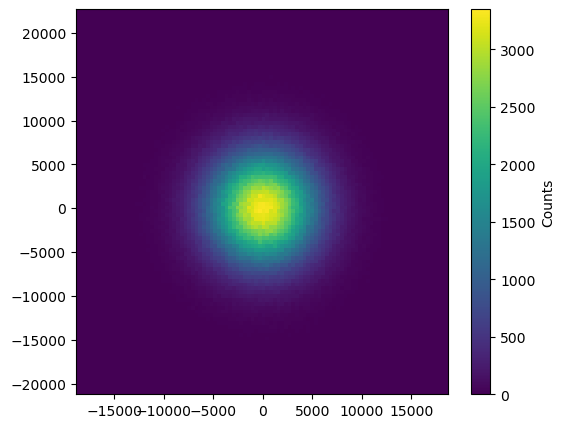

In [4]:
x = df['to_x']
y = df['to_y']

plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='viridis')

plt.colorbar(label='Counts')

In [5]:
X = df[['from_x', 'from_y', 'to_x', 'to_y', 'day_type', 'start']]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Preprocessing

In [18]:
# TODO create a preprocessing function
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model definition

## architecture

In [7]:
model = Sequential([
    Dense(64, activation='relu', kernel_initializer=HeNormal(), input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(16, activation='relu', kernel_initializer=HeNormal()),
    Dense(4, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='exponential')
    #Dense(1, activation='softplus')
])

## loss function

In [ ]:
def asymetric_loss_function(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tf.debugging.assert_greater(
        tf.reduce_min(y_true), tf.constant(0.0, dtype=tf.float32),
        message="y_true contains zero or negative values!"
    )
    
    ratio = y_pred / (y_true * 0.9)
    tf.debugging.assert_non_negative(
        ratio,
        message="Ratio is negative!"
    ) 
    loss = tf.where(ratio <= 1, (1-ratio)**2, 7* tf.math.log(ratio))
    
    return tf.reduce_mean(loss)

## compile

In [9]:
model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])

# Training

In [10]:
history = model.fit(X_train_scaled, y_train, epochs=8, batch_size=16, validation_split=0.2)

Epoch 1/8
80000/80000 [==============================] - 238s 3ms/step - loss: 0.2375 - mape: 43.5385 - val_loss: 0.1428 - val_mape: 34.4389
Epoch 2/8
80000/80000 [==============================] - 232s 3ms/step - loss: 0.1395 - mape: 35.3144 - val_loss: 0.1295 - val_mape: 33.1575
Epoch 3/8
80000/80000 [==============================] - 230s 3ms/step - loss: 0.1319 - mape: 34.5548 - val_loss: 0.1265 - val_mape: 32.8681
Epoch 4/8
80000/80000 [==============================] - 231s 3ms/step - loss: 0.1280 - mape: 34.1359 - val_loss: 0.1240 - val_mape: 34.3205
Epoch 5/8
80000/80000 [==============================] - 231s 3ms/step - loss: 0.1259 - mape: 33.9220 - val_loss: 0.1206 - val_mape: 32.3470
Epoch 6/8
80000/80000 [==============================] - 231s 3ms/step - loss: 0.1246 - mape: 33.7949 - val_loss: 0.1202 - val_mape: 34.2798
Epoch 7/8
80000/80000 [==============================] - 231s 3ms/step - loss: 0.1232 - mape: 33.6402 - val_loss: 0.1311 - val_mape: 37.7499
Epoch 8/8
800

In [ ]:
model.save('model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpqj4upv3p\assets


# Model evaluation

## Read tflite model

In [ ]:
with open('model.tflite', 'rb') as f:
    tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## predicitons on test set

In [ ]:
y_pred = []

for i in range(X_test_scaled.shape[0]):
    single_row = X_test_scaled[i].reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(output_data[0][0])

y_pred = np.array(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 0.34%
Predictions: [4854.7686 5051.9023 1575.4077 1029.2772 3839.039  1254.9733 2597.1519
 4332.3735 1236.3501 7780.1177]
Actual values: 290952      6960
1022390     6696
390018      2241
943449      1455
1260991     7476
806721      2219
54519       5187
793459      4772
749031      1954
913820     15225
Name: time, dtype: int32


## Visualize set results distribution

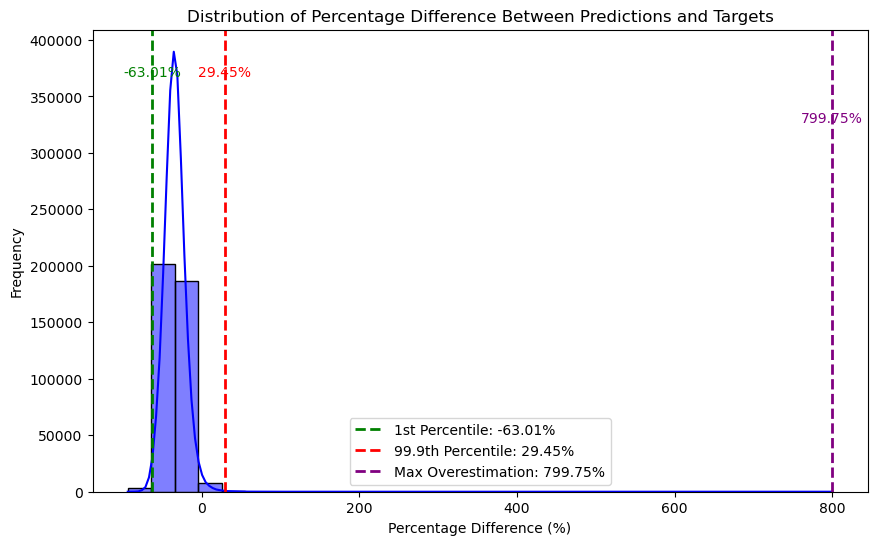

Maximal Overestimation Value: 799.75%
Percentile for 0 on x-axis value: 98.79%


In [23]:
percentage_difference = ((y_pred - y_test) / y_test) * 100

percentile_1 = np.percentile(percentage_difference, 1)
percentile_99 = np.percentile(percentage_difference, 99.9)
max_overestimation = np.max(percentage_difference)
percentile_of_0 = percentileofscore(percentage_difference, 0)

plt.figure(figsize=(10, 6))
sns.histplot(percentage_difference, kde=True, bins=30, color='blue')

plt.axvline(percentile_1, color='green', linestyle='--', linewidth=2, label=f'1st Percentile: {percentile_1:.2f}%')
plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_99:.2f}%')

plt.text(percentile_1, plt.ylim()[1] * 0.9, f'{percentile_1:.2f}%', color='green', ha='center')
plt.text(percentile_99, plt.ylim()[1] * 0.9, f'{percentile_99:.2f}%', color='red', ha='center')

plt.axvline(max_overestimation, color='purple', linestyle='--', linewidth=2, label=f'Max Overestimation: {max_overestimation:.2f}%')
plt.text(max_overestimation, plt.ylim()[1] * 0.8, f'{max_overestimation:.2f}%', color='purple', ha='center')

plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Difference Between Predictions and Targets')
plt.legend()
plt.show()

print(f'Maximal Overestimation Value: {max_overestimation:.2f}%')
print(f'Percentile for 0 on x-axis value: {percentile_of_0:.2f}%')

## Forward pass time

In [24]:
y_pred = []

for i in range(X_test_scaled.shape[0]):
    single_row = X_test_scaled[i].reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(output_data[0][0])

y_pred = np.array(y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Test MAPE using TensorFlow Lite: {test_mape}')

# Print a few predictions
for pred, actual in zip(y_pred[:5], y_test[:5]):
    print(f'Predicted: {pred:.4f}, Actual: {actual:.4f}')

Test MAPE using TensorFlow Lite: 0.3431444290022166
Predicted: 4854.7686, Actual: 6960.0000
Predicted: 5051.9023, Actual: 6696.0000
Predicted: 1575.4077, Actual: 2241.0000
Predicted: 1029.2772, Actual: 1455.0000
Predicted: 3839.0391, Actual: 7476.0000


In [ ]:
num_iterations = 10000
total_time = 0

for _ in range(num_iterations):
    random_index = np.random.randint(0, X_test_scaled.shape[0])
    single_row = X_test_scaled[random_index].reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    
    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    total_time += (end_time - start_time)

average_forward_pass_time = (total_time / num_iterations) * 1e6
print(f"Average forward pass time for a single row using TensorFlow Lite: {average_forward_pass_time:.6f} microseconds")
print(f"total time for 10000 rows: {total_time*1000} milliseconds")

Average forward pass time for a single row using TensorFlow Lite: 6.581640 microseconds
total time for 10000 rows: 65.81640243530273 milliseconds
